# Calcul des "*Golden Scores*"

## I - Introduction

L'idée principale du projet est d'évaluer des métriques qui mesurent la performance de systèmes de traduction. Un des premiers critères à considérer est leur corrélation avec le jugement humain. Les données du WMT22 nous permettent d'affecter un score humain à chaque traduction candidate des systèmes considérés via le calcul des scores **MQM** (Multidimensional Quality Metrics). Le **MQM** est un type de **Golden Score** car il correspond à un score basé sur les erreurs identifiées par les experts humains.

Nous disposons de trois paires de langages source (**sl** pour "source langage") et langages cibles (**tl** pour "target langage") :

- *English-German* : **ende**
- *Chinese-English* : **zhen**
- *English-Russian* : **enru**

Pour chacune de ces trois paires, nous disposons de deux bases de données issues du GitHub Google MQM Human Evaluation (https://github.com/google/wmt-mqm-human-evaluation) :

1 - **Base de données "Liste Candidats"** : répertorie les traductions de différents modèles de langage (**hyp** pour hypothèse), les phrases source (**source**), les traductions de référence établies par des experts (**ref** pour référence). 

2 - **Base de données "Correction des Candidats"** : répertorie l'ensemble des erreurs faites par les modèles de traduction. Un expert humain a annoté pour chaque traduction candidate de chaque système les erreurs de traduction, en indiquant pour chaque erreur son type et sa sévérité, c'est à dire s'il s'agit d'une faute importante ou non. 

Ici, le MQM pour chaque traduction candidate se calcule comme la somme sur toutes les erreurs identifiées des poids associés à leur sévérité. Les poids sont donc à percevoir comme des pénalités, où le score de la traduction se voit décrémenté d'une certaine valeur pour chaque erreur commise. Formellement, on peut écrire : 

\begin{equation}
MQM_{hyp} = - \sum_{error \in Errors} w_{error} 
\end{equation}

Le barème des poids par type d'erreur provient du concours WMT 2021, et deux tableaux récapitulatifs provenant de l'article *"Results of the WMT21 Metrics Shared Task: Evaluating Metrics with Expert-based Human Evaluations on TED and News Domain"* (https://aclanthology.org/2021.wmt-1.73/) dresse une liste exhaustive de ceux ci. La table 2 (Google MQM) est utilisée pour les paires *English-German* : **ende** et *Chinese-English* : **zhen**. La table 3 (Unlabel MQM) est utilisée pour la paire *English-Russian* : **enru**.

### I.1 - *English-German* (**ende**) et *Chinese-English* (**zhen**) : **Google's MQM error**

<img src="./figures/google_mqm_score.png" alt="Employee data" width="250" height="250" title="Employee Data title">

### I.2 - *English-Russian* (**enru**) : **Unlabel's MQM error**

<img src="./figures/unlabel_mqm_score.png" alt="Employee data" width="300" height="300" title="Employee Data title">

### I.3 - Classe WMT22 pour Calcul des scores

L'ensemble des fonctions permettant de calculer les MQM scores pour les trois paires de traductions sont à retrouver dans **/code/data_processing** : 
- **MQM_google_score** : calcul des MQM scores pour la partie I.1
- **MQM_unlabel_score** : calcul des MQM scores pour la partie I.2
- **data_golden_scores** : formation des bases de données de traductions annotées des scores MQM, et enregistrement sous le nom WMT22_w_golden_scores_sltl
- **read_data** : lecture de la base de données déjà annotée des scores (pour éviter le recalcul des scores à chaque session de travail).

## II - Création base avec Golden Scores

In [12]:
# IMPORTS :
import numpy as np
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
import sys
from tqdm import tqdm

# FUNCTIONS / CLASSES :
%load_ext autoreload
%autoreload 2
sys.path.append("./code")
from data_processing import WMT22

## DICTIONNAIRE DES COUPLES DE TRADUCTIONS :
sl_tls = {
    "ende" : "English-German",
    "enru" : "English-Russian",
    "zhen" : "Chinese-English" 
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## PARCOURS DES COUPLES DE TRADUCTION POSSIBLES :
for key in sl_tls.keys() :
    
    val = sl_tls[key]
    
    ## ACCES AUX DONNEES DE TRAIN ET DEV :
    df = WMT22.data_golden_scores(sl_tl = key)
    
    ## NOMBRE D'OBSERVATIONS :
    print(val , " : " , len(df) , " observations" )
    

English-German  :  32190  observations


/Users/henriup/Desktop/project_nlp/./code/data_processing.py:145: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_rates = pd.read_table("./data/generalMT2022/" + sl_tl + "/mqm_generalMT2022_" + sl_tl + ".tsv",


English-Russian  :  32348  observations
Chinese-English  :  35188  observations


## III - Lecture des données

In [2]:
df = WMT22.read_data()

In [8]:
## PARCOURS DES COUPLES DE TRADUCTION POSSIBLES :
for key, val in sl_tls.items() :
    
    query = df[df.sltl == key]
    
    ## NOMBRE D'OBSERVATIONS :
    print(val , " : " , len(query) , " observations" )
    
    print(df.sample(3)[["ref", "hyp", "score"]])
    
    print("\n")

English-German  :  32190  observations
                                                     ref  \
12683  Gehen Sie einfach auf die Seite mit Ihrer Best...   
15648  Es kam mehrmals vor (in verschiedenen Lockdown...   
23912  Easyhome still needs to be improved with a lot...   

                                                     hyp  score  
12683  Um dies zu tun, gehen Sie einfach auf Ihre Bes...   -5.4  
15648  Bei mehreren Gelegenheiten (durch verschiedene...   -1.0  
23912  Actually the home still needs to be upgraded, ...   -5.0  


English-Russian  :  32348  observations
                                                     ref  \
21904  Tippen Sie auf das Symbol „Mehr“ unten rechts ...   
17380  Они гордятся званием одного из последних произ...   
4344   Is your $32 discount code only applicable when...   

                                                     hyp  score  
21904  Tippen Sie auf das Symbol Mehr unten rechts au...    0.0  
17380  Они очень гордятся тем, что являют

## IV - Visualisations

### 1 - Usual statistics for translation pairs

In [13]:
num_segments = []
avg_score = []
mean_tokens = []

for key, val in tqdm(sl_tls.items()) :
    
    query = df[df.sltl == key]
    
    num_segments.append(len(query.seg_id.unique()))
    avg_score.append(query.score.mean())
    
    tokens = query.apply(lambda x : len(TweetTokenizer().tokenize(x.hyp)), axis = 1)
    mean_tokens.append(tokens.mean())

100%|█████████████████████████████████████████████| 3/3 [00:09<00:00,  3.12s/it]


In [14]:
res = pd.DataFrame(data = {
    "sl-tl" : sl_tls.keys(),
    "num-segments" : num_segments, 
    "avg-hyps-len" : mean_tokens,
    "avg-score" : avg_score,
}).set_index("sl-tl")

In [15]:
res

,num-segments,avg-hyps-len,avg-score
sl-tl,,,
ende,2027,19.649550,-0.749637
enru,2027,18.073946,-1.766632
zhen,1875,29.278049,-1.767983


### 2 - Golden Score distribution by translation pair

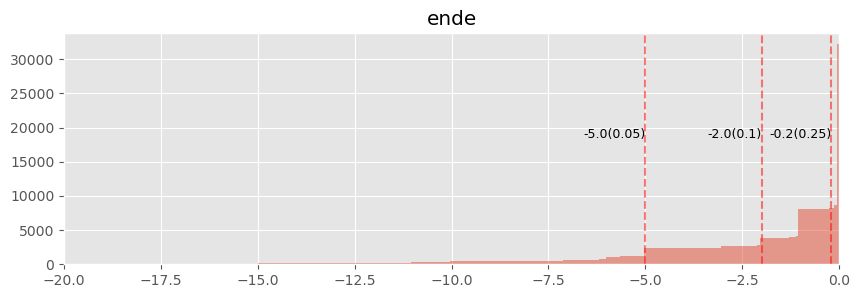

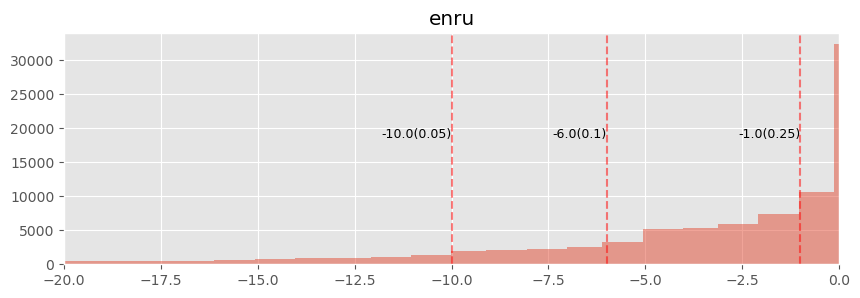

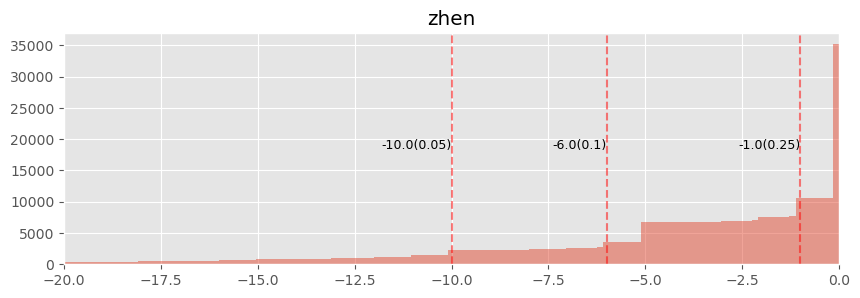

In [128]:
for sl_tl in sl_tls.keys():
    
    query = df[df.sltl == sl_tl]

    fig, ax = plt.subplots(figsize = (10,3))

    query.score.hist(
        ax=ax,
        cumulative=True,
        bins=500,
        alpha=0.5
    )
    
    quantiles = [0.05, 0.1, 0.25]

    quartiles = query.score.quantile(quantiles)

    for i, q in enumerate(quartiles.values):
        ax.axvline(q, linestyle='--', color='red', alpha=0.5)
        ax.annotate("{}({})".format(q, quantiles[i]), xy=(q, 20000), xytext=(q, 20000), 
                ha='right', va='top', fontsize=9, 
                arrowprops=dict(arrowstyle="->", linestyle=":", linewidth=1))

    ax.set_xlim([-20, 0])
    plt.title(sl_tl)

### 3 - Number of observations by domain and translation pair

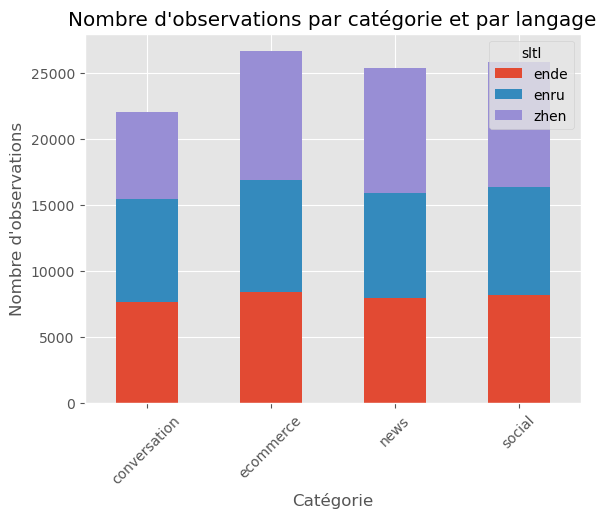

In [74]:
grouped = df.groupby(["domain", "sltl"]).score.count().unstack()
ax = grouped.plot(
    kind = "bar",
    stacked = True
)

ax.set_xlabel("Catégorie")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Nombre d'observations par catégorie et par langage")

ax.set_xticklabels(grouped.index, rotation=45)

plt.show()